# Projeto 1 - Métodos de Aprendizagem Não Supervisionada

### Grupo
- Ismael Pereira Santos de Melo - RA175460
- Willian Massahiro Hayashida - RA188705

Este projeto consiste no estudo de dois diferentes métodos de aprendizagem não supervisionada, o k-means e a clusterização hierárquica, além de um método de redução de dimensionalidade, o PCA. Seu principal objetivo é aprimorar os conhecimentos em relação aos método e a conceitos gerais de aprendizado de máquina.

## PARTE I - Métodos de Clusterização
---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rd

from math import sqrt

X = pd.read_csv('data/cluster.dat', delimiter=' ', header=0, names=['x1', 'x2'])
X.head()

,x1,x2
0,1490.0,27.55
1,1445.0,28.35
2,1415.0,28.80
3,1375.0,28.05
4,1335.0,28.45


Podemos nos benecificiar de análises visuais uma vez que o modelo é bi-dimensional.

<AxesSubplot:xlabel='x1', ylabel='x2'>

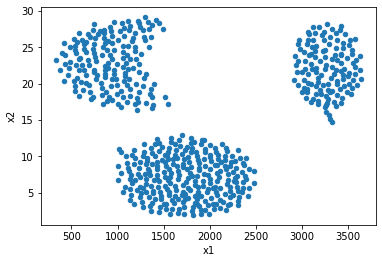

In [ ]:
X.plot(x='x1', y='x2', kind='scatter')

Para nosso problema de clusterização, percebemos visualmente que 3 será um bom valor para o número de clusters, mas será confirmado posteriormente por meio do método do cotovelo e silhueta.

### Splitting Dataset

---

Separamos o conjunto de dados em treinamento e teste, seguindo:

- 90% - training set
- 10% - test set

In [ ]:
def splitDataset(X, train_size):
    X = X.sample(frac=1).reset_index(drop=True)
    th_index = int(X.shape[0] * train_size)
    return X[:th_index].values, X[th_index:].values

In [ ]:
X_training, X_test = splitDataset(X, 0.9)

### Helper - functions definition

- feature scaling
- mean normalization (implemented but not used, see comments inside the function)
- random_iniatilization

In [ ]:
def featureScaling(X_b):
    """
    Setting data between a range of [0, 1]
    
    Parameters
    ----------
    X_b : numpy array
        The dataset to be normalized.
    Returns
    -------
    minmax_scaling : numpy array
        Column normalized
    """
    m = X.shape[0]

    max_x = max(X_b)
    min_x = min(X_b)

    s = max_x - min_x

    return (X_b - min_x) / s

def meanNormalization(X_b):
    """
    por praticidade, decidimos não utilizar nossa implementação,
    uma vez que precisariamos salvar os coeficientes para normalizar o conjunto de teste
    com os mesmo valores.
    Assim, podemos focar nossos esforços nas implementações e analises dos algoritmos de treinamento.
    
    """
    u = X_b.mean(axis=1)
    X_b = np.subtract(X_b, u[:,None])

    max_x = X_b.max(axis=1)
    min_x = X_b.min(axis=1)
    s = max_x - min_x

    return np.divide(X_b, s[:, None])

def random_initialization(X_b, k, random_state=42):
    """
    Create random cluster centroids.
    
    Parameters
    ----------
    X_b : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """
    np.random.seed(random_state)
    centroids = []
    m = np.shape(X_b)[0]

    for i in range(k):
        r = np.random.randint(0, m-1)
        centroids.append(X_b[r])

    return centroids

### Preparing the Dataset

In [ ]:
X_training[:,0] = featureScaling(X_training[:,0])
X_training[:,1] = featureScaling(X_training[:,1])


X_test[:,0] = featureScaling(X_test[:,0])
X_test[:,1] = featureScaling(X_test[:,1])


### Learning Algorithm
---
Definição de duas funções
- assign_cluster -> cluster assignment
- k_means -> learning algorithm

In [ ]:
def assign_cluster(X, k, centroids):
    """
    Assign each point x_i in X to a centroid
    ----------
    ## Parameters
    X : numpy array
        The input dataset
    k : integer
        The number of centroids
    centroids : numpy array

    -------
    ## Returns
    cluster_index: numpy array
        The Array that map that point i was assigned to centroid cluster_index[i]
    buckets : array
        Array with all points assigned to cluster i
    """
    m = X.shape[0]
    
    buckets = {}
    for i in range(k):
        buckets[i] = []
    
    # for each point, find the closest cluster
    cluster_index = np.zeros(m)
    for i in range(m):
        # get point p_i
        point = X[i: i+1]

        # fill dist with the distances 
        #   between p_i and each centroid
        dist = []
        for c in range(k):
            dist.append(np.linalg.norm(point - centroids[c]))
        
        ind = np.argmin(dist)            # find centroid c_ind closest to p_i
        buckets[ind].append(point)       # add p_i to the bucket of c_ind
        cluster_index[i] = ind           # assign p_i to cluster c_ind

    return cluster_index, buckets



def k_means(X, k, tolerance=0.001, n_epoch=100):
    m = X.shape[0]
    f = X.shape[1]
  
    buckets = {}                                     # build an array to feed with all points assigned to cluster i
    cluster_index_hist = []                          # array to save cluster to which each point was assigned
    centroids_hist= []                               # array to save centroids

    # random initialization
    centroids = random_initialization(X, k)

    # iterates until reach limit
    for epoch in range(n_epoch):
        # forward
        cluster_index, buckets = assign_cluster(X, k, centroids)
        
        centroids_previous = centroids.copy()
        # recompute centroids based on all points in its bucket
        for i in range(k):
            centroids[i] = np.average(buckets[i], 0)[0]
            buckets[i] = []

    
        cluster_index_hist.append(cluster_index.copy())
        centroids_hist.append(centroids_previous)

        isOptimal = True

        for i in range(k):
            previous = centroids_previous[i]
            current = centroids[i]
            
            if np.sum((current - previous)/previous * 100.0) > tolerance:
                isOptimal = False
            
        if isOptimal:
            break

    return centroids_hist, cluster_index_hist

### Training Model

In [ ]:
k = 3
n_epoch = 100
centroids_array, cluster_labels = k_means(X_training, k, tolerance=0.001, n_epoch=n_epoch)

Podemos plotar a execução do k_means. Cada cor no gráfico representa um dos três clusteres, enquanto os círculos brancos representam os centróides.

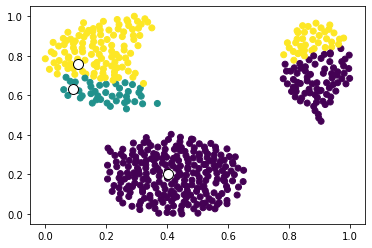

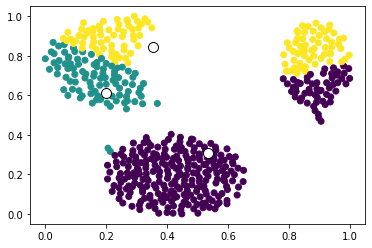

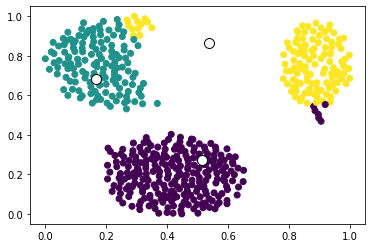

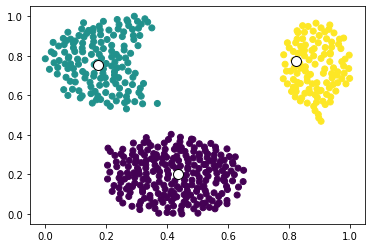

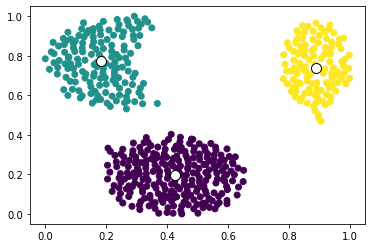

In [ ]:
centroids_array = np.array(centroids_array)
X_res = X_training.copy()

n = len(cluster_labels)

for i in range(n):
    index = int((n / 5) * i)
    X_plot = np.insert(X_res, 2, cluster_labels[index], axis=1)
    plt.figure()
    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=X_plot[:, 2])
    plt.scatter(centroids_array[index,:, 0], centroids_array[index, :, 1], s=100, ec='k', color='white')
    plt.show()

### Avaliando possíveis valores de k (número de clusters)

Aplicando método do cotovelo para análise visual

In [ ]:
def elbowAnalysis(X, tolerance=0.001, n_epoch = 100):
    sse = []
    for k in range(1,8):
        centroids_array, cluster_labels = k_means(X, k, tolerance, n_epoch=n_epoch)
        
        m = len(X)
        num_features = X.shape[1]

        centroids_array = np.array(centroids_array)
        index = len(centroids_array) -1
        
        centers = centroids_array[index,:,:]
        df = pd.DataFrame(np.insert(X, 2, cluster_labels[index], axis=1))
        
        d = 0
        for i in range(k):
            X_linha = df.loc[df[2] == i].drop(columns=[2]).values

            d += np.sum(np.sum((X_linha - centers[i])**2, axis=1)**0.5)
        sse.append([k,d])

    return np.array(sse)

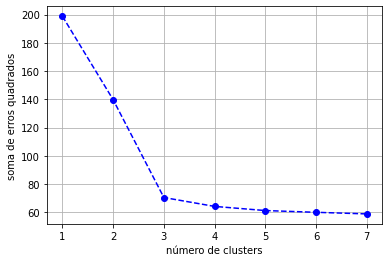

In [ ]:
sse = elbowAnalysis(X_training)

plt.figure()
plt.plot(sse[:,0], sse[:,1], 'bo')
plt.plot(sse[:,0], sse[:,1], 'b--')
plt.grid(True)
plt.xlabel("número de clusters")
plt.ylabel("soma de erros quadrados")
plt.show()

A partir da análise do gráfico, observamos que o 3 é o número ótimo para quantidade clusters.

### Análise de silhueta

Podemos melhorar nossa análise olhando a coesão dos pontos pela silhueta.

In [ ]:
# code from
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def silhoutteAnalysis(X, range_n_clusters, tolerance=0.001, n_epoch=100):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        plt.figure()
        ax1 = plt.axes()

        plt.xlim([-0.1, 1])
        plt.ylim([0, len(X) + (n_clusters + 1) * 10])

        centroids_array_silhouette, cluster_labels = k_means(X, n_clusters, tolerance, n_epoch)
        m = len(cluster_labels)
        cluster_labels = cluster_labels[m-1]
        centroids_array_silhouette = np.array(centroids_array_silhouette)
        
        index = len(centroids_array_silhouette) -1
        centers = centroids_array_silhouette[index,:,:]

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontweight='bold')

        plt.show()

For n_clusters = 2 The average silhouette_score is : 0.4517714461319421


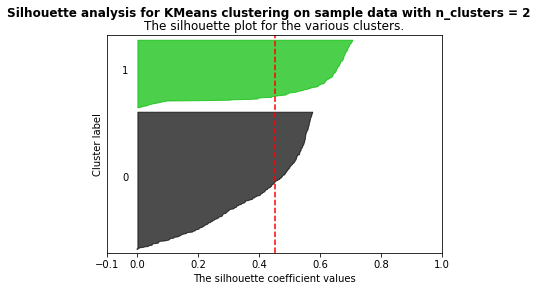

For n_clusters = 3 The average silhouette_score is : 0.69568064450951


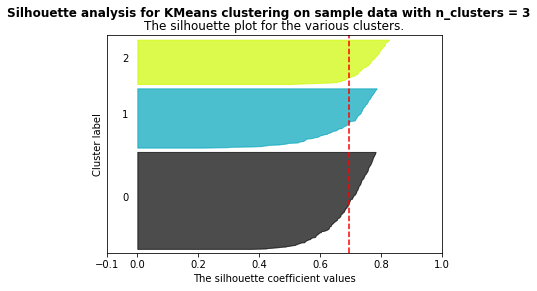

For n_clusters = 4 The average silhouette_score is : 0.5903018524387011


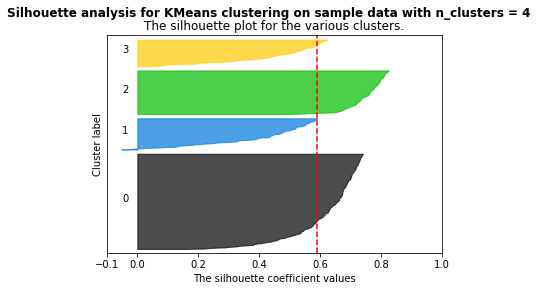

For n_clusters = 5 The average silhouette_score is : 0.5755148582631906


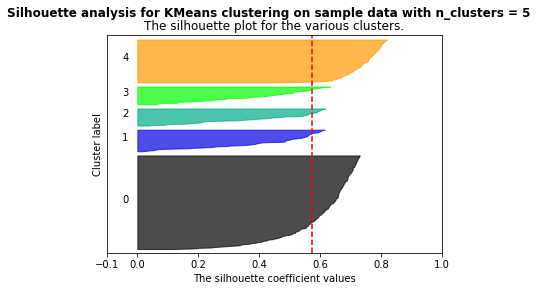

For n_clusters = 6 The average silhouette_score is : 0.5556418026861024


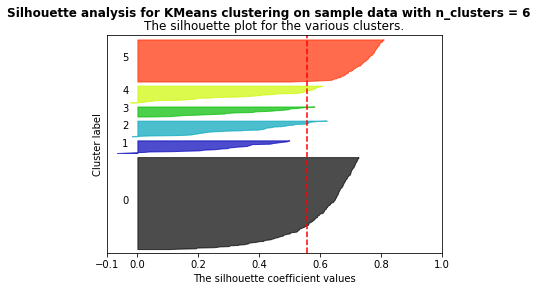

In [ ]:
X_silhouette = X_training.copy()

range_n_clusters = [2, 3, 4, 5, 6]
silhoutteAnalysis(X_silhouette, range_n_clusters, tolerance=0.001, n_epoch=100)


O resultado com melhor pontuação é de fato a configuração com 3 clusters.

O score foi de: 0.69

### Testando o modelo

Com os centroides inicializados podemos agrupar os pontos no conjunto de teste.

In [ ]:
index = len(centroids_array) -1
centroids = centroids_array[index,:,:]
k = 3
cluster_labels, buckets_test = assign_cluster(X_test, k, centroids)

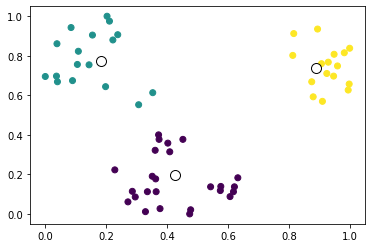

In [ ]:
X_res = X_test.copy()

X_plot = np.insert(X_res, 2, cluster_labels, axis=1)
plt.figure()
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=X_plot[:, 2])
plt.scatter(centroids[:,0], centroids[:,1], s=100, ec='k', color='white')
plt.show()

Visualmente percebemos que o modelo apresentou bom desempenho.

In [ ]:
df = pd.DataFrame(np.insert(X_test, 2, cluster_labels, axis=1))

d = 0

for i in range(k):
    X_linha = df.loc[df[2] == i].drop(columns=[2]).values

    d += np.sum(np.sum((X_linha - centroids[i])**2, axis=1)**0.5)

print('Soma de erros quadrados:')
print(d)

Soma de erros quadrados:
8.66534275951294


## Clusterização Hierárquica

Além do k-means, implementamos também o método de clusterização hierárquica, que obteve um resultado similar mas com um custo de execução extremamente superior, levando cerca de 25 minutos para completar a clusterização, dado o dataset proposto, enquanto o k-means completa a clusterização em poucos segundos.

In [ ]:
def hierarchical_clustering(x):
    m = x.shape[0]
    f = x.shape[1]

    clusters = {}

    for i in range(m):
        clusters[i] = []

    for i in range(m):
        clusters[i].append(x[i])

    # print(clusters)
    while(len(clusters) > 3):

        m = len(clusters)
        
        distances = np.zeros((m, m), float)
        
        #Para cada clusters i e j, calcula a distância entre os dois
        for i in range(m):
            for j in range(m):
                centro_i = np.average(clusters[i], 0)
                centro_j = np.average(clusters[j], 0)
                distances[i][j] = ((centro_i[0] - centro_j[0])**2 + (centro_i[1] - centro_j[1])**2)**0.5  

        maisProximos = localizaCelulaComMenorValor(distances)

        #Une os dois clusters mais próximos
        clusters[maisProximos[0]].extend(clusters[maisProximos[1]])

        #Exclui o cluster que foi englobado pelo outro
        clusters[maisProximos[1]] = clusters[len(clusters)-1].copy()
        del clusters[len(clusters)-1]
    
    x = []
    for i in range(len(clusters)):
        for j in clusters[i]:
            x.append(np.append(j,[i]))
    return x

def localizaCelulaComMenorValor(matriz):
    resp = (0, 1)
    menor = matriz[0][1]
    for lin in range(len(matriz)):
        for col in range(len(matriz[lin])):
            if matriz[lin][col] < matriz[resp[0]][resp[1]] and matriz[lin][col] != 0:
                menor = matriz[lin][col]
                resp = (lin, col) 
    return resp


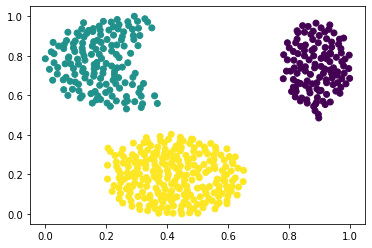

In [ ]:
X_plot = hierarchical_clustering(X_training)
X_plot = np.array(X_plot)
plt.figure()
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=X_plot[:, 2])
plt.show()

## PARTE II - Redução de Dimensionalidade

Para essa parte do trabalho escolhemos o conjunto de dados de câncer de mama disponível em

https://www.kaggle.com/uciml/breast-cancer-wisconsin-data




In [ ]:
XII = pd.read_csv('data/data.csv', delimiter=',')
print(XII.shape)
XII.head() 

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
# we are removing the ID and the target from our dataset
XII = XII.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
XII.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Preparando o conjunto de dados

Separando em conjunto de treinamento e conjunto de teste

In [ ]:
XII_training_raw, XII_test_raw = splitDataset(XII, 0.9)

Normalizando os dados

In [ ]:
# XII_training_norm = meanNormalization(XII_training_raw)
# XII_test_norm = meanNormalization(XII_test_raw)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(XII_training_raw)
# Apply transform to both the training set and the test set.
XII_training_norm = scaler.transform(XII_training_raw)
XII_test_norm = scaler.transform(XII_test_raw)

Agora podemos verificar que temos média perto de zero e desvio padrão igual a 1

In [ ]:
np.mean(XII_training_norm),np.std(XII_training_norm)

(-1.2692393432563638e-17, 1.0)

### PCA

Utilizamos a biblioteca do scikit learning para redução de dimensionalidade

In [ ]:
from sklearn.decomposition import PCA

# pedimos ao PCA que encontre um subconjunto com variancia maior que 99%
pca = PCA(n_components = 0.99)

pca.fit(XII_training_norm)

XII_training = pca.transform(XII_training_norm)
XII_test = pca.transform(XII_test_norm)
print('número de componentes')
print(XII_training.shape[1])

número de componentes
17


Podemos visualizar a variancia pelo número de componentes

Text(0, 0.5, 'cumulative explained variance')

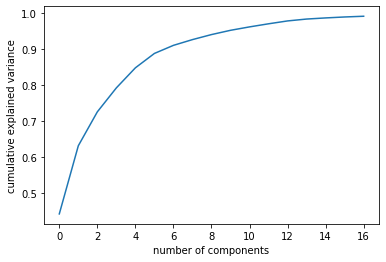

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Realizamos uma implementação própria do PCA para entendimento do método, que pode ser vista abaixo, mas optamos por utilizar nas análises apenas a solução fornecida pela biblioteca.


In [ ]:
# XII_training = XII_training_norm.copy()
# XII_test = XII_test.copy()

# m = XII_training.shape[1]
# for i in range(m):
#     XII_training[:,i] = featureScaling(XII_training_norm[:,i])
#     XII_test[:,i] = featureScaling(XII_test[:,i])


# m = XII_training.shape[1]
# sigma  = (1/m) * XII_training.T.dot(XII_training)
# U,S,V = np.linalg.svd(sigma, full_matrices=True)

# k = S.shape[0]
# for i in range(k):
#     calc = np.sum(S[:i]) / np.sum(S)
#     print(i, calc)
#     if 1 - calc <= 0.01:
#         best_k = i
#         break

# Ureduce = U[:, :best_k]
# z = XII_training.dot(Ureduce)
# z.shape

### Análise do cotovelo

Tendo o conjunto um total de 17 dimensões, fica um pouco complicado uma determinação visual para um bom valor de k.

Fazemos a análise do cotovelo para encontrar um bom valor de k.

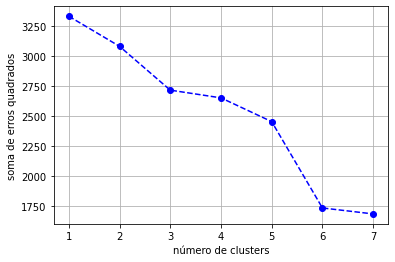

In [ ]:
sse = elbowAnalysis(XII_training)

plt.figure()
plt.plot(sse[:,0], sse[:,1], 'bo')
plt.plot(sse[:,0], sse[:,1], 'b--')
plt.grid(True)
plt.xlabel("número de clusters")
plt.ylabel("soma de erros quadrados")
plt.show()

Vemos que 6 é um bom valor de k.

### Análise da Silhueta

Podemos confirmar o valor encontrado anteriormente fazendo a análise de coesão dos clusters.

For n_clusters = 2 The average silhouette_score is : 0.13648698650288682


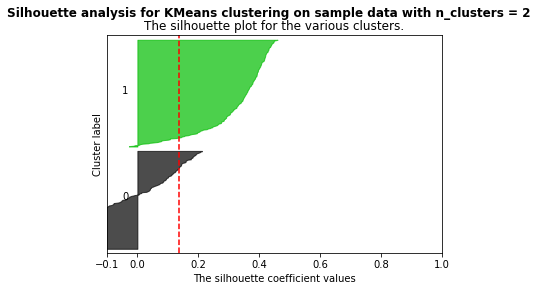

For n_clusters = 3 The average silhouette_score is : 0.07595969651731212


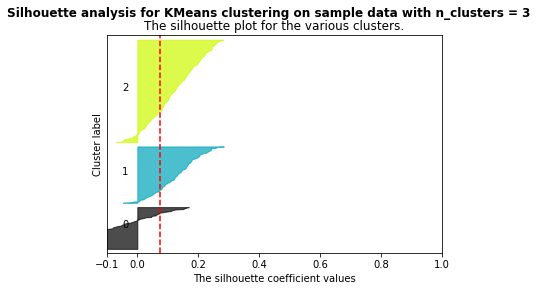

For n_clusters = 4 The average silhouette_score is : 0.08891019037426509


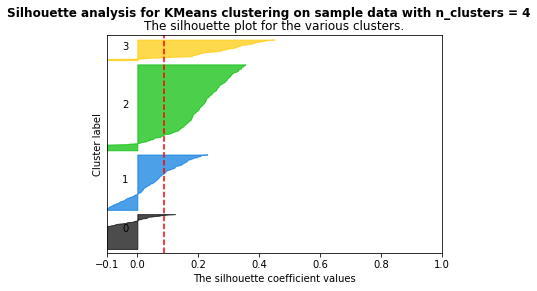

For n_clusters = 5 The average silhouette_score is : 0.08217397582352018


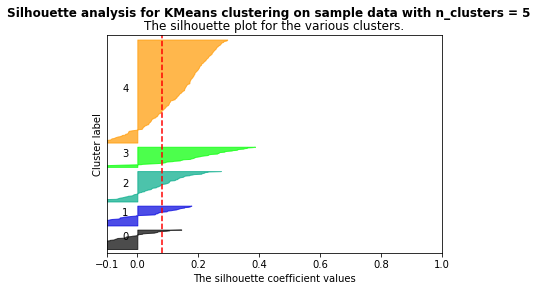

For n_clusters = 6 The average silhouette_score is : 0.14458199084048073


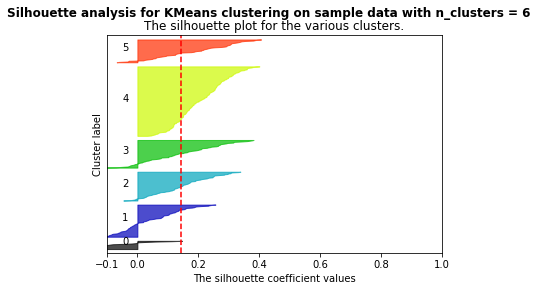

For n_clusters = 7 The average silhouette_score is : 0.13732841558598133


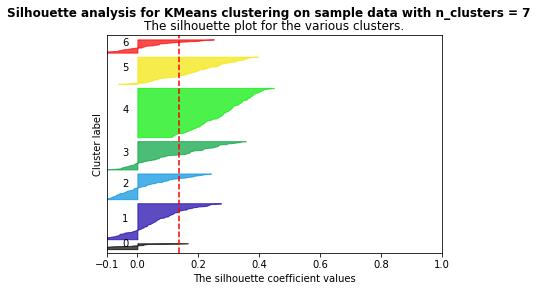

For n_clusters = 8 The average silhouette_score is : 0.11330953153751448


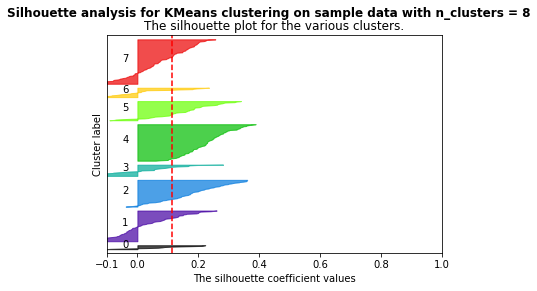

In [ ]:
X_silhouette = XII_training.copy()

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhoutteAnalysis(X_silhouette, range_n_clusters, tolerance=0.0005, n_epoch=250)

O modelo não converge tão bem quanto o problema da parte I, o melhor resultado que tivemos foi com 6 clusters que teve um score de 0.1445.

### Treinamento do modelo

In [ ]:
k = 6
n_epoch = 100
centroids_array, ind = k_means(XII_training, k, tolerance=0.001, n_epoch=n_epoch)
centroids_array = np.array(centroids_array)

### Validando o modelo

In [ ]:
index = len(centroids_array) -1
centroids = centroids_array[index,:,:]
k = 3
cluster_labels, buckets_test = assign_cluster(XII_test, k, centroids)

In [ ]:
df = pd.DataFrame(np.insert(XII_test, 2, cluster_labels, axis=1))

d = 0

for i in range(k):
    X_linha = df.loc[df[2] == i].drop(columns=[2]).values

    d += np.sum(np.sum((X_linha - centroids[i])**2, axis=1)**0.5)

print('Soma de erros quadrados:')
print(d)

Soma de erros quadrados:
239.80724111198418


## Contribução Individual
William: Responsável pela implementação do algoritmo do k-means, pela análise da silhueta e pelo PCA.

Ismael: Responsável pela implementação do algoritmo da clusterização hierárquica e pelo método do cotovelo.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c868fb48-964e-4083-a3f6-d09a9b8e14ec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>